# Bootstrap vs Jackknife
Julian Hsu
24-Aug-2024

The purpose of this script is to compare the performance of the bootstrap and jackknife over different sample sizes and simulations.

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline  

import statsmodels.api as sm

from IPython.display import display    


In [82]:
def random_data(n=1000, coef= 1):
    x1 = np.random.uniform(-1,1, n)
    w = np.random.choice(2, n)
    y = np.random.uniform() + coef*w + np.random.normal(0, 1, n)
    return pd.DataFrame(data={'x1': x1, 'w':w, 'y':y})

def ols(data=None):
    beta = sm.OLS(endog = data['y'], exog=sm.add_constant(data[['x1','w']])).fit().params['w']
    return beta

def bootstrap(data=None, reps=100):
    beta_list = []
    for r in range(reps):
        sim_data = data.sample(frac=1, replace=True)
        beta_hat = ols(data=sim_data)
        beta_list.append(beta_hat)
    return beta_list 

def jknife(data=None):
    beta_list = []
    for n in range(len(data)):
        sim_data = data.loc[data.index!=n]
        beta_hat = ols(data=sim_data)
        beta_list.append(beta_hat)
    return beta_list 


In [92]:
samplesize_list = [50,100,300]
btsim_list = [50,100, 150, 200, 500]
df_results= pd.DataFrame()
for samplesize in samplesize_list:
    entry_data={}
    df = random_data(n = samplesize)
    jknife_results = jknife(data=df)
    entry_data['n']= samplesize
    entry_data['jknife_se'] = (samplesize/(samplesize-1)) * np.var(jknife_results)
    for btsim in btsim_list:
        bootstrap_results = bootstrap(data=df, reps=btsim)
        entry_data['bt'] = btsim 
        entry_data['bt_se'] = (1/(btsim-1))*np.var(bootstrap_results) 
        df_results= pd.concat([df_results, pd.DataFrame(index=[samplesize], data=entry_data)])

C:\Users\tarob\AppData\Local\Temp\ipykernel_12264\3109332311.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_.sort_values(by='bt', inplace=True)


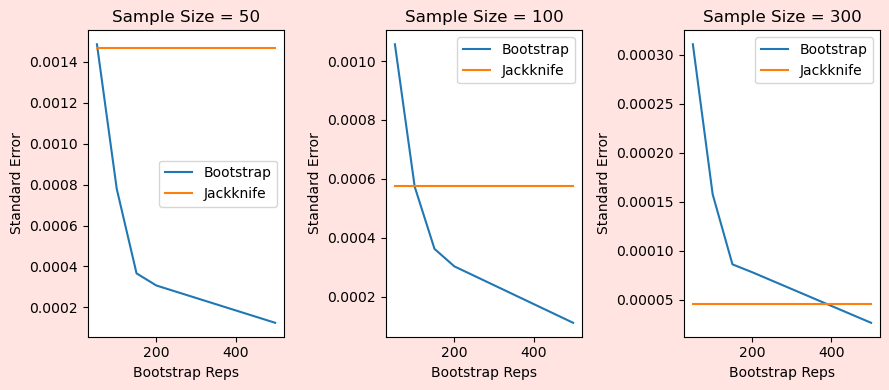

In [93]:
fig,ax = plt.subplots(ncols=len(samplesize_list),nrows=1,figsize=(3*len(samplesize_list),4))
for po in enumerate(samplesize_list):
    plot_ = df_results.loc[df_results['n']==po[1]]
    plot_.sort_values(by='bt', inplace=True)
    ax[po[0]].plot(plot_['bt'], plot_['bt_se'], label='Bootstrap')
    ax[po[0]].plot(plot_['bt'], plot_['jknife_se'], label='Jackknife')
    ax[po[0]].set_xlabel('Bootstrap Reps')
    ax[po[0]].set_ylabel('Standard Error')
    ax[po[0]].legend()
    ax[po[0]].set_title('Sample Size = {0}'.format(po[1]))
plt.tight_layout()
fig.set_facecolor('mistyrose')
plt.show()


** sound byte**: The most threatening thing I've asked is "Have you tried a jackknife?" When calculating confidence intervals and standard errors, we often rely on theorems of statistical inference not all are comfortable with. A popular "shortcut" is to calculate them by resampling your data many times - aka the bootstrap. A "shortcut" on top of that (meta-cut?) is to do resample by "leaving one out" meaning you do far fewer resamples - aka the jackknife. 

Using simulated data, I show the popular result that the jackknife will over-estimate standard errors and hence lead to less precise results. As you do more bootstrapping resamples, the standard error eventually becomes lower than that from the jackknife. You can find the sample notebook here: 
